# Simple Text Embedding

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn(verbose = False)

ModuleNotFoundError: No module named 'sklearnex'

#### 1) Import Text Data

In [3]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

In [4]:
from sklearn.datasets import fetch_20newsgroups

# Import training data
twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

# Import test data
twenty_test = fetch_20newsgroups(subset='test',
    categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data

In [5]:
twenty_train.target_names
twenty_train.target # Array of different values

array([1, 1, 3, ..., 2, 2, 2], dtype=int64)

In [6]:
len(twenty_train.data) # Articles

2257

In [7]:
twenty_train.data[0] # First element

'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n'

In [8]:
print(twenty_train.data[0])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [9]:
print(twenty_train.target_names[twenty_train.target[0]])

comp.graphics


In [10]:
twenty_train.target[0:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2], dtype=int64)

#### 2) Text Vectorization Example with Bag of Words and TF-IDF

#### Part 1: Bag of words and TF-IDF Separately

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(lowercase = True, min_df = 1e-3) # Word appears less than 1/1000, then word is not important
#Some arguments: max_features=1500, min_df=5, max_df=0.7, ngram_range=(1,2), stop_words=nltk.stopwords.words('english')
X_train_counts = count_vect.fit_transform(twenty_train.data) # Matrix


In [12]:
X_train_counts.shape # 35K words

(2257, 13105)

In [13]:
X_train_counts

<2257x13105 sparse matrix of type '<class 'numpy.int64'>'
	with 337814 stored elements in Compressed Sparse Row format>

In [14]:
X_train_counts[2,4]

0

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 13105)

In [16]:
X_train_tfidf[0, 10]

0.0

#### Part 2: Both at Once

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer()#max_features=1500, min_df=5, max_df=0.7, ngram_range=(1,2)
X_train_tfidf = tfidfconverter.fit_transform(twenty_train.data)
X_train_tfidf.shape

(2257, 35788)

#### 3) Text Classification

In [18]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class="multinomial", solver="newton-cg")
clf.fit(X_train_tfidf, twenty_train.target)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [19]:
from sklearn.metrics import accuracy_score
X_test_tfidf = tfidfconverter.transform(twenty_test.data)
X_test_tfidf.shape
y_hat = clf.predict(X_test_tfidf)
accuracy_score(twenty_test.target, y_hat)

0.8974700399467377

In [20]:
from sklearn.pipeline import Pipeline
text_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logistic", LogisticRegression(multi_class="multinomial", solver="newton-cg"))
])

In [21]:
text_pipe.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg'))])

In [22]:
y_hat = text_pipe.predict(twenty_test.data)
accuracy_score(twenty_test.target, y_hat)

0.8974700399467377

#### 4) Tuning the Hyper-parameters

In [23]:
from sklearn.model_selection import KFold, GridSearchCV

In [24]:
# Define folds
folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid
my_grid = {
    "tfidf__max_features": [1500, None],
    "logistic__C": [1, 10]
}

# Define grid search CV
tfidf_logistic_cv = GridSearchCV(
    estimator=text_pipe,
    param_grid=my_grid,
    scoring="accuracy",
    cv=folds
)

In [25]:
# Run CV
tfidf_logistic_cv.fit(twenty_train.data, twenty_train.target)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logistic',
                                        LogisticRegression(multi_class='multinomial',
                                                           solver='newton-cg'))]),
             param_grid={'logistic__C': [1, 10],
                         'tfidf__max_features': [1500, None]},
             scoring='accuracy')

In [26]:
pd.DataFrame(tfidf_logistic_cv.cv_results_)
tfidf_logistic_cv.best_params_
tfidf_logistic_cv.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic',
                 LogisticRegression(C=10, multi_class='multinomial',
                                    solver='newton-cg'))])

In [27]:
best_model = tfidf_logistic_cv.best_estimator_
best_model.fit(twenty_train.data, twenty_train.target)
y_hat = best_model.predict(twenty_test.data)
accuracy_score(twenty_test.target, y_hat)

0.914780292942743

#### 5) Model Diagnostics

In [30]:
from yellowbrick.classifier import confusion_matrix, class_prediction_error

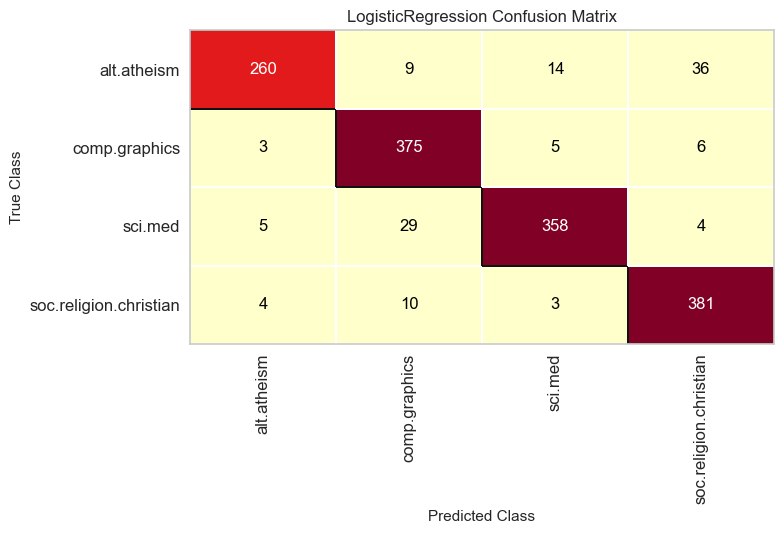

In [31]:
confusion_matrix(best_model,
                 twenty_train.data, twenty_train.target,
                 twenty_test.data, twenty_test.target,
                 classes=twenty_test.target_names);

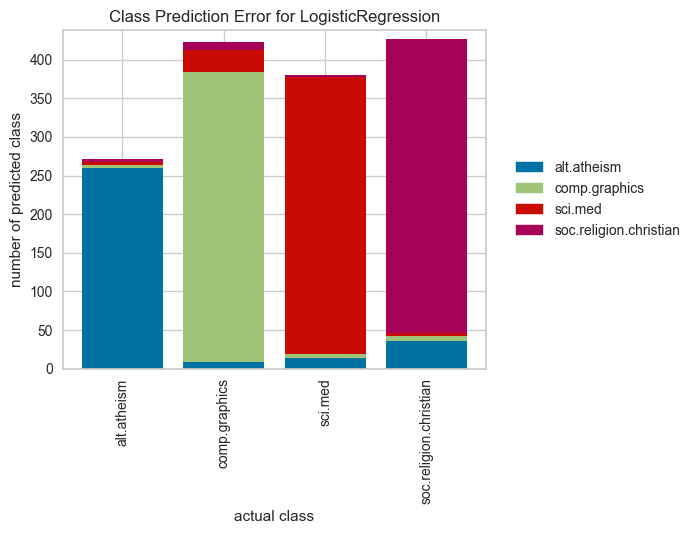

In [32]:
class_prediction_error(best_model,
                       twenty_train.data, twenty_train.target,
                       twenty_test.data, twenty_test.target,
                       classes=twenty_test.target_names);

#### 6) Predict Some Sentences

In [33]:
docs_new = ['God is love', 'Lungs and heart health', "CPU or GPU?"]

predicted = best_model.predict(docs_new)

for doc, category in zip(docs_new, predicted):
    print(doc, "=>", twenty_train.target_names[category])

God is love => soc.religion.christian
Lungs and heart health => sci.med
CPU or GPU? => comp.graphics
